# Inosoft Technical Test - Amazon Stock Price Prediction
- Naoby Prawira

# Import Libraries


In [ ]:
# Basic Data and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Training Data Processing and Model Development Libraries
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

# For model saving (timestamping and directory management)
import datetime
import os

# Load Dataset

In [171]:
df=pd.read_csv('Test Macine Learning Enginer Inosoft_AMZN.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


# Set Date as Index

In [ ]:
df.set_index('Date',inplace = True)

In [ ]:
df.index =  pd.to_datetime(df.index,format='%Y-%m-%d') # Convert the index to datetime format

In [40]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


# Exploratory Data Analysis

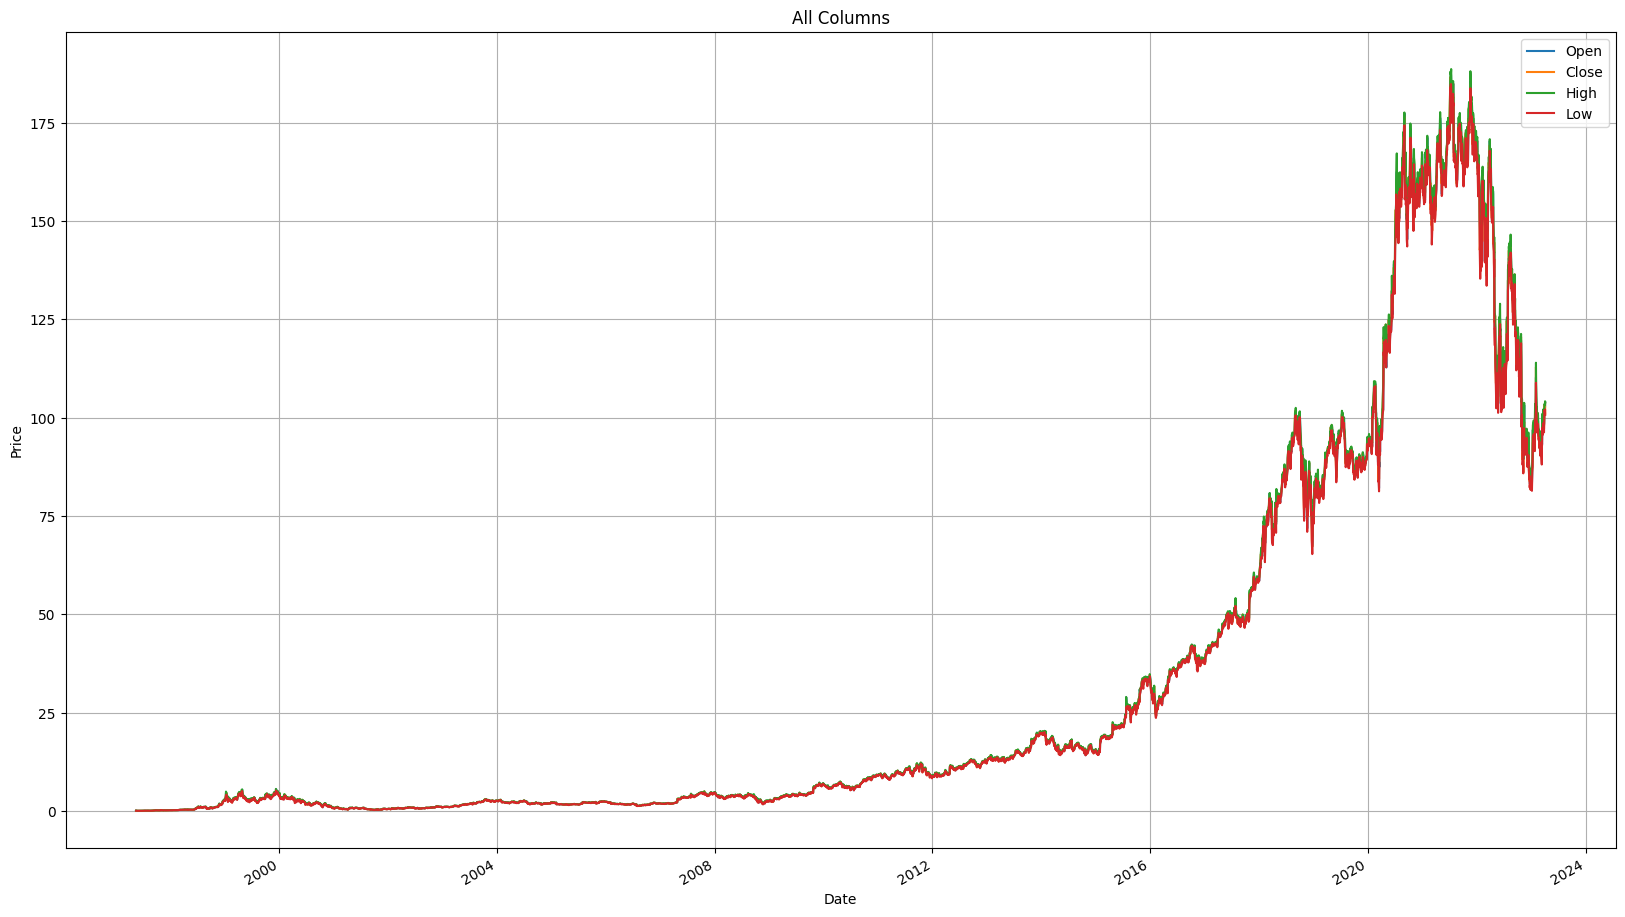

In [87]:
df[['Open','Close','High','Low']].plot(figsize = (20,12))
plt.title('All Columns')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Sesuai instruksi, kita lihat grafik persebaran value dan detect anomali di kolom Close.

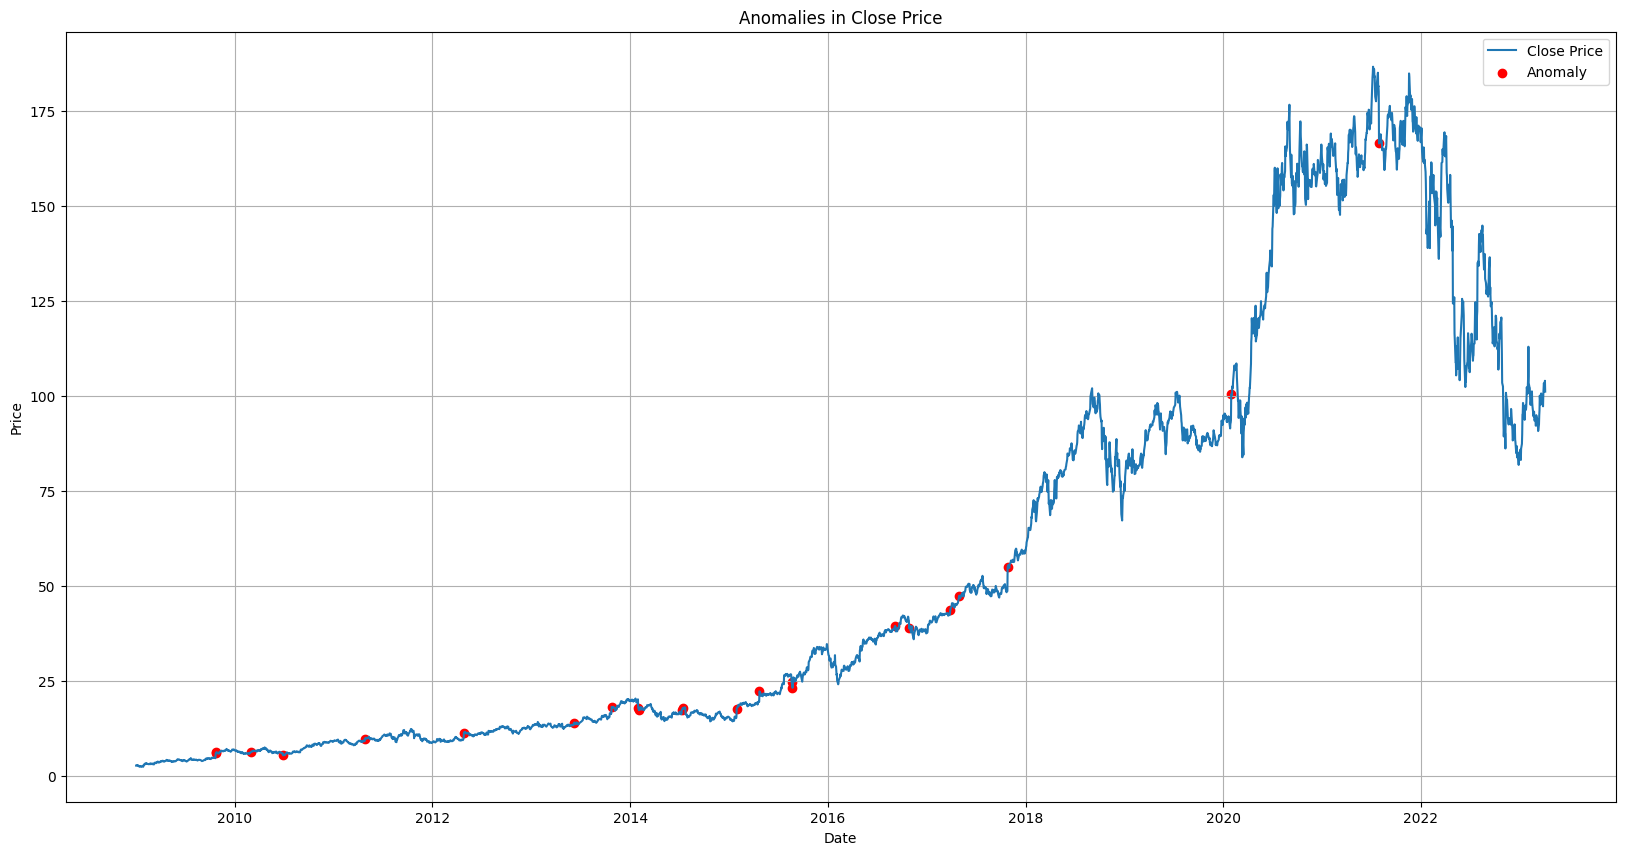

In [ ]:
def detect_anomalies(data, column, threshold=3):
    # Calculate rolling mean and std
    rolling_mean = data[column].rolling(window=20).mean()
    rolling_std = data[column].rolling(window=20).std()
    
    # Calculate z-score
    z_score = (data[column] - rolling_mean) / rolling_std
    
    # Identify anomalies
    data['anomaly'] = (abs(z_score) > threshold).astype(int)
    data['z_score'] = z_score
    
    return data

# Apply anomaly detection
anomaly_df = detect_anomalies(df.copy(), 'Close')

# Visualize the anomalies
plt.figure(figsize=(20, 10))
plt.plot(anomaly_df.index, anomaly_df['Close'], label='Close Price')
plt.scatter(anomaly_df[anomaly_df['anomaly'] == 1].index, 
            anomaly_df[anomaly_df['anomaly'] == 1]['Close'], 
            color='red', label='Anomaly')
plt.title('Anomalies in Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Pada grafik di atas, anomali yang dihighlight tidak terlalu signifikan (tetap normal dalam konteks harga saham), sehingga dapat disimpulkan tidak ada kesalahan format atau nilai yang tidak normal.

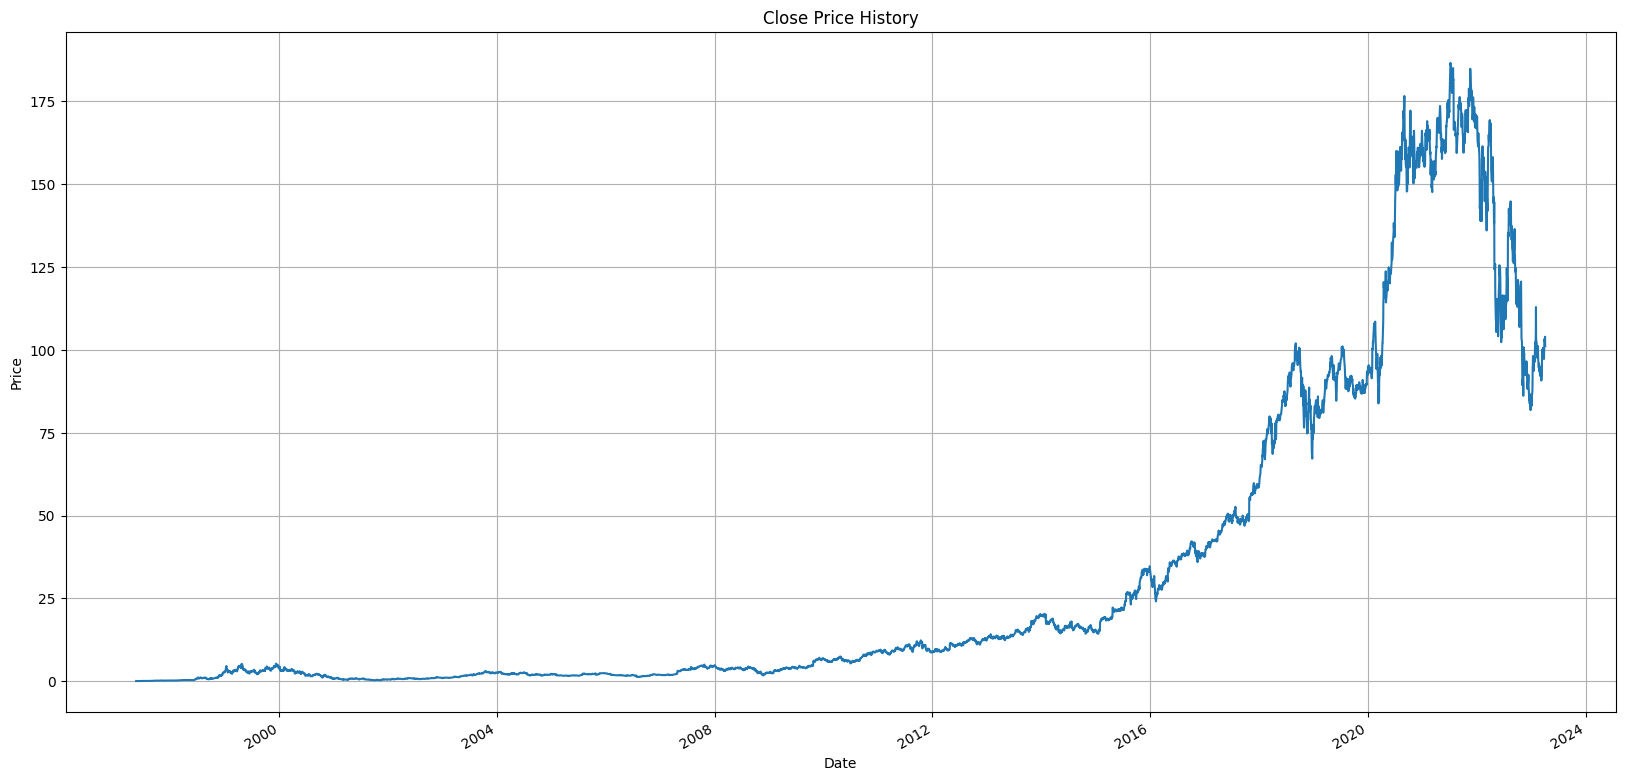

In [86]:
df['Close'].plot(figsize = (20,10))
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Dari grafik di atas, terlihat bahwa closing price/harga saham Amazon cukup stagnan hingga sekitar 2009, baru setelahnya mengalami kenaikan dan mulai fluktuatif. Maka ada 2 approach yang dapat dilakukan:
1. Tetap gunakan keseluruhan data
2. Gunakan data mulai dari 2009

Disini saya akan coba approach kedua dengan alasan:

- Terlihat bahwa mulai dari 2009 harga saham cenderung mulai fluktuatif dan seterusnya tidak tampak akan terjadi stagnan,
- Dengan memilih data training yang variatif, diharapkan model tidak bias ke pola harga yang stagnan dan lebih akurat menangkap pola fluktuatif dari harga saham. 

In [89]:
df = df['2009':'2024']

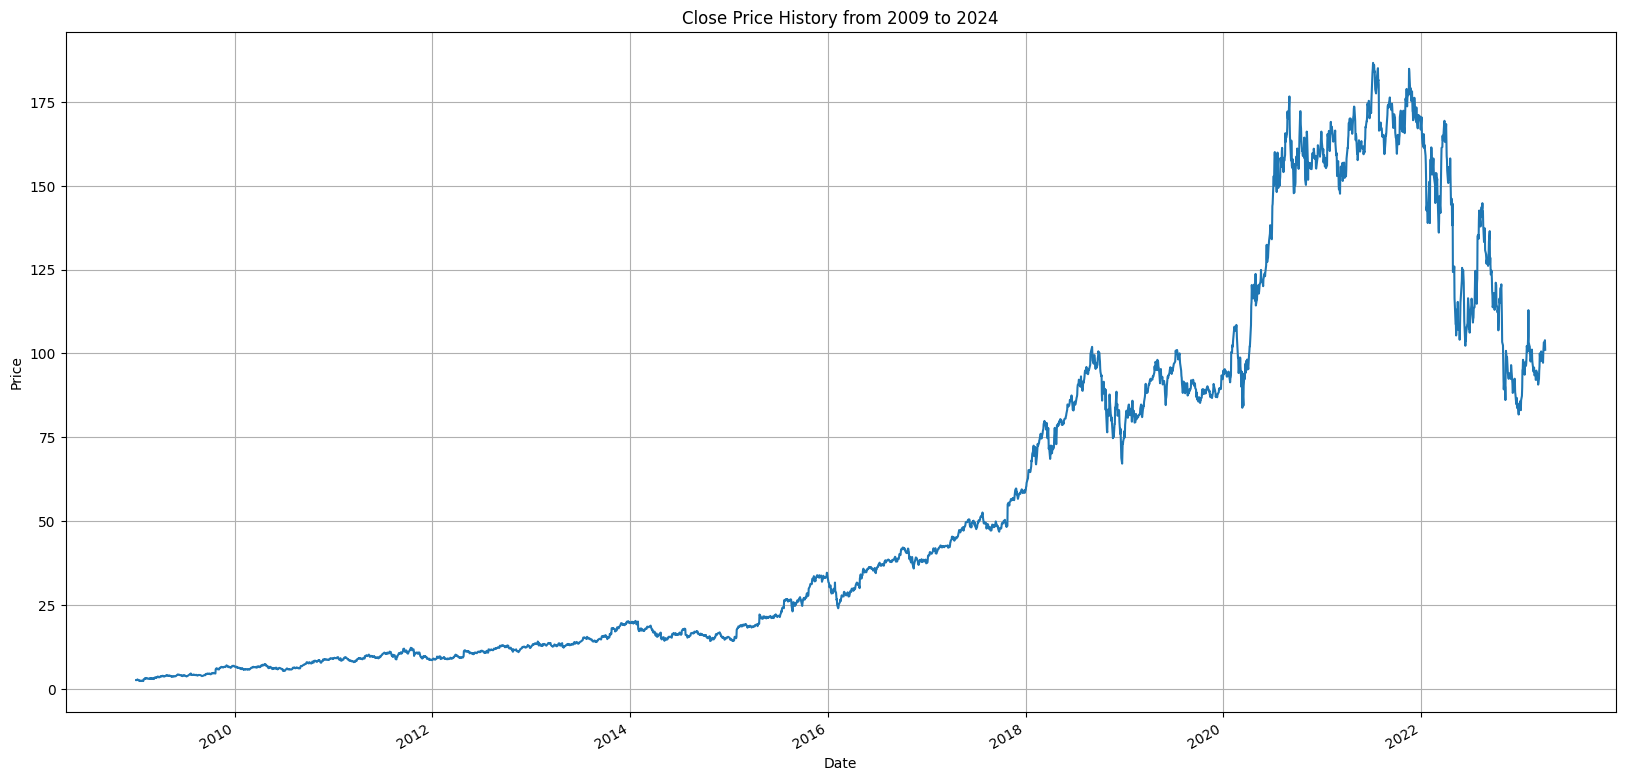

In [90]:
df['Close'].plot(figsize = (20,10))
plt.title('Close Price History from 2009 to 2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Model

## Callback function

Callback function digunakan mengontrol keseluruhan arah model nantinya, seperti:
1. Menghentikan training bila mencapai akurasi tertentu untuk mencegah overfitting
2. Kembali ke iterasi dengan performa yang terbaik
3. Menyimpan weight pada tiap "checkpoint" tertentu, agar jika ada kendala tidak mengharuskan training dari awal (jika tidak memungkinkan).

In [ ]:
# ini callback function yang saya gunakan untuk training model deep learning secara general.

EPOCHS = 150
patience = 10

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def getMetrics(type_):
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics('loss'))<=0.00001)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics('val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '.weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics('val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]
callbacks_ = getCallbacks('Simple_RNN')

In [ ]:
# pisahkan df['close] untuk forecasting
price = df['Close']

# Buat array untuk sequences
X = []
y = []

for i in range(2, len(price)):
    X.append(price[i-2:i])
    y.append(price[i])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

C:\Users\naoby\AppData\Local\Temp\ipykernel_13392\1959453963.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(price[i])


Training data shape: (2869, 2, 1)
Testing data shape: (718, 2, 1)


## Training Model

In [ ]:
# Inisiasi model RNN sesuai instruksi
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

c:\Users\naoby\Downloads\inosoft-technical-test\inosoft-tech-test\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,901 (15.24 KB)

 Trainable params: 3,901 (15.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS,
    batch_size=8, 
    validation_split=0.2,
    callbacks=callbacks_,
    verbose=1
)

Epoch 1/150


257/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 412.8877
Epoch 1: val_loss improved from inf to 4610.08594, saving model to Simple_RNN.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 409.7617 - val_loss: 4610.0859 - learning_rate: 1.0000e-05
Epoch 2/150
278/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185.8877
Epoch 2: val_loss improved from 4610.08594 to 18.21124, saving model to Simple_RNN.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 182.6530 - val_loss: 18.2112 - learning_rate: 1.0800e-04
Epoch 3/150
278/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3502
Epoch 3: val_loss improved from 18.21124 to 4.01356, saving model to Simple_RNN.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3481 - val_loss: 4.0136 - learning_rate: 2.0600e-04
Epoch 4/150
276/287 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2191
Epoch 4: val_loss improved from 4.01356 to 3.64629, saving model to Simple_RNN.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2198

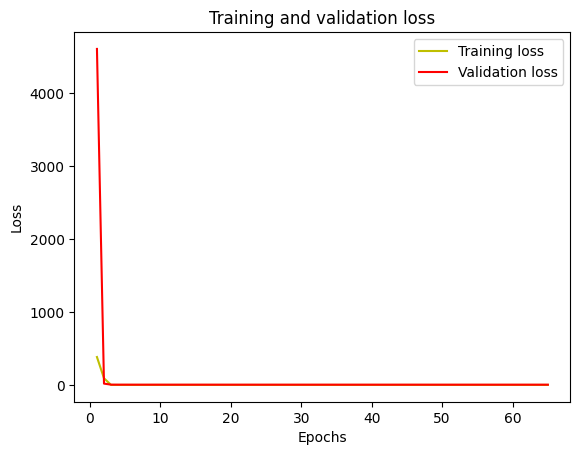

In [138]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Testing

In [163]:
# Reshape data testing
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

training_data_preds = model.predict(X_train)
testing_data_preds = model.predict(X_test)

print('Train rmse:', np.sqrt(mean_squared_error(y_train, training_data_preds)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, testing_data_preds)))

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train rmse: 0.921535401316275
Validation rmse: 3.4394166170292273


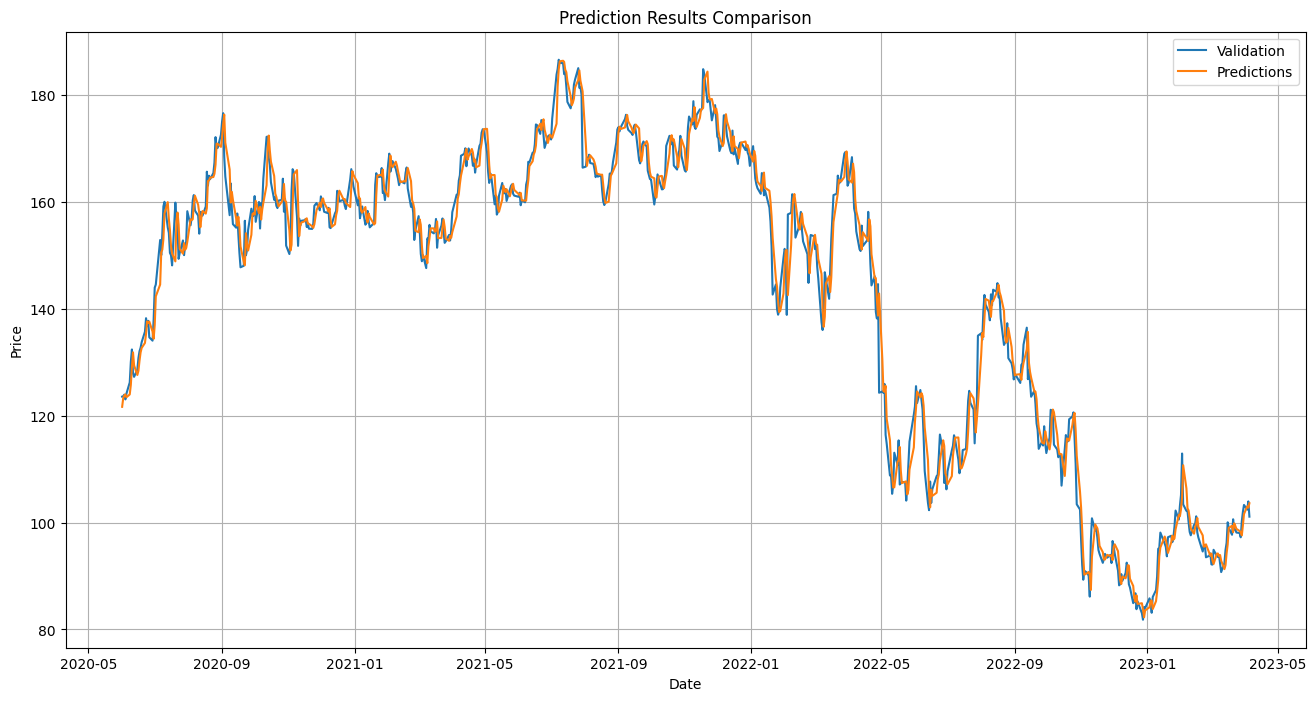

In [170]:
valid = pd.DataFrame(df[2871:])
valid['Predictions']=testing_data_preds 
plt.figure(figsize=(16,8))
plt.title('Prediction Results Comparison')
plt.plot(valid[['Close','Predictions']])
plt.legend(['Validation','Predictions'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

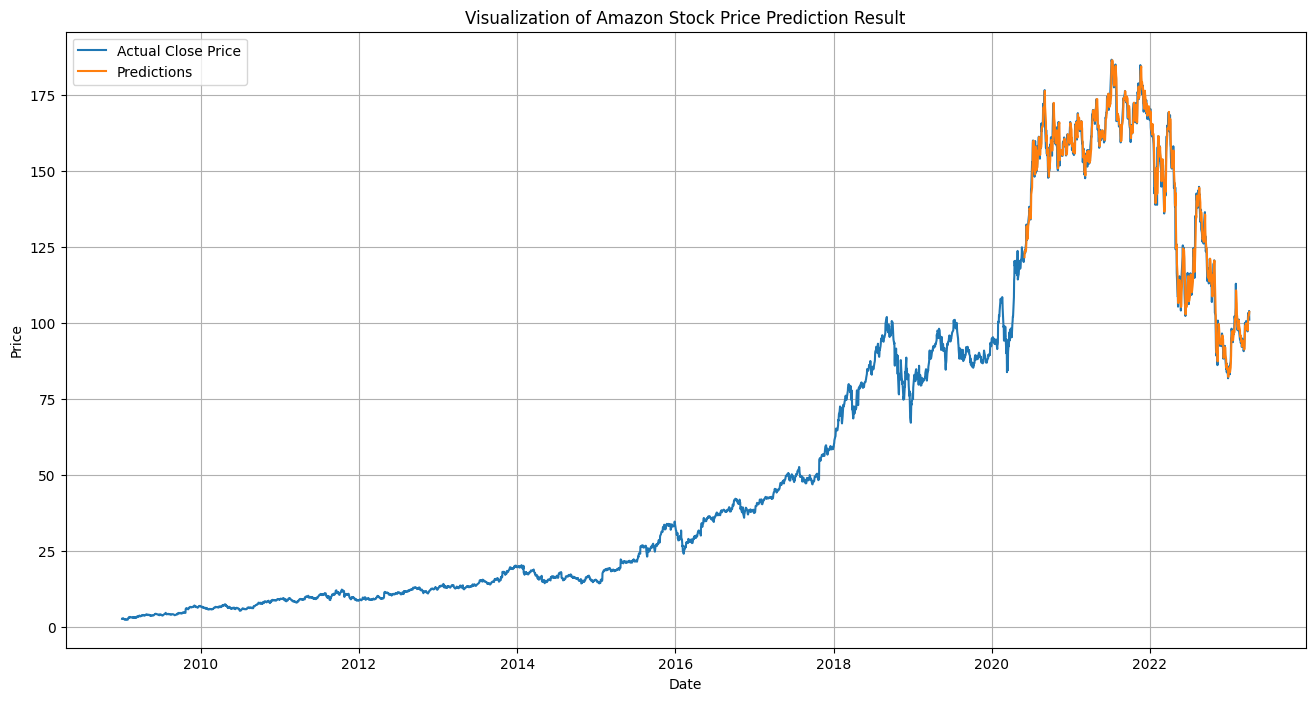

In [166]:
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Actual Close Price')
plt.plot(valid.index, valid['Predictions'], label='Predictions')
plt.title('Visualization of Amazon Stock Price Prediction Result')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Save Model

In [ ]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Get current date for model versioning
current_date = datetime.datetime.now().strftime("%Y%m%d")
model_name = f"Amazon_RNN_model_{current_date}"

# H5
model.save(f'saved_models/{model_name}.h5')
print(f"Model saved in HDF5 format: saved_models/{model_name}.h5")

# TF SavedModel
model.export(f'saved_models/{model_name}')
print(f"Model saved in SavedModel format: saved_models/{model_name}")

Model saved in HDF5 format: saved_models/Amazon_RNN_model_20250517.h5
INFO:tensorflow:Assets written to: saved_models/Amazon_RNN_model_20250517\assets


INFO:tensorflow:Assets written to: saved_models/Amazon_RNN_model_20250517\assets


Saved artifact at 'saved_models/Amazon_RNN_model_20250517'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name='keras_tensor_42')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1746419807824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746419809552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746419809360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746419806096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746419808208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746419809168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1746419808976: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved in SavedModel format: saved_models/Amazon_RNN_model_20250517


# Conclusion

Dari notebook ini, dapat dilihat bahwa model RNN yang dibuat sudah cukup baik dalam memprediksi harga saham Amazon tersebut.

Berikut hasil RMSE pada data training dan validasi:

- Train: 0.92
- Validation: 3.44

Error yang dihasilkan ~2-3% (kesalahan sekitar 1 hingga 3.5 dollar) dari harga saham Amazon pada data yang berkisar antara $1-$103.
Hasil tersebut menunjukkan bahwa model tidak dapat digunakan untuk memprediksi harga saham Amazon secara akurat pada tingkat harian. Namun, model ini sudah dapat memberikan gambaran umum tentang tren harga saham Amazon pada rentang mingguan, bulanan, hingga tahunan.




Meski begitu, berikut beberapa hal yang bisa di-improve atau dilakukan eksperimen untuk meningkatkan akurasi model:
1. Model atau teknik lain, seperti ARIMA (untuk statistikal), atau variasi dari RNN seperti LSTM atau GRU.
2. Hyperparameter tuning.
